<a href="https://colab.research.google.com/github/YooNayoung/ESAA/blob/main/%EC%8B%A4%EC%8A%B5%ED%95%84%EC%82%AC%2BChap4_CNN(05).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flower Recognition CNN Keras**

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/ESAA(OB)/flowers'))

['dandelion', 'rose', 'sunflower', 'tulip', 'daisy']


## **1 ) Importing Various Modules**

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## **2 ) Preparing the Data**

### 2.1) Making the functions to get the training and validation set from the Images

In [ ]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/ESAA(OB)/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/ESAA(OB)/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/ESAA(OB)/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/ESAA(OB)/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/ESAA(OB)/flowers/rose'

In [ ]:
def assign_label(img,flower_type):
    return flower_type

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [ ]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:11<00:00, 64.25it/s] 

764


In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:14<00:00, 51.48it/s] 

1497


In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:15<00:00, 62.84it/s] 

2481


In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:16<00:00, 62.96it/s] 

3533


In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:11<00:00, 68.71it/s] 

4317


### 2.2 ) Visualizing some Random Images

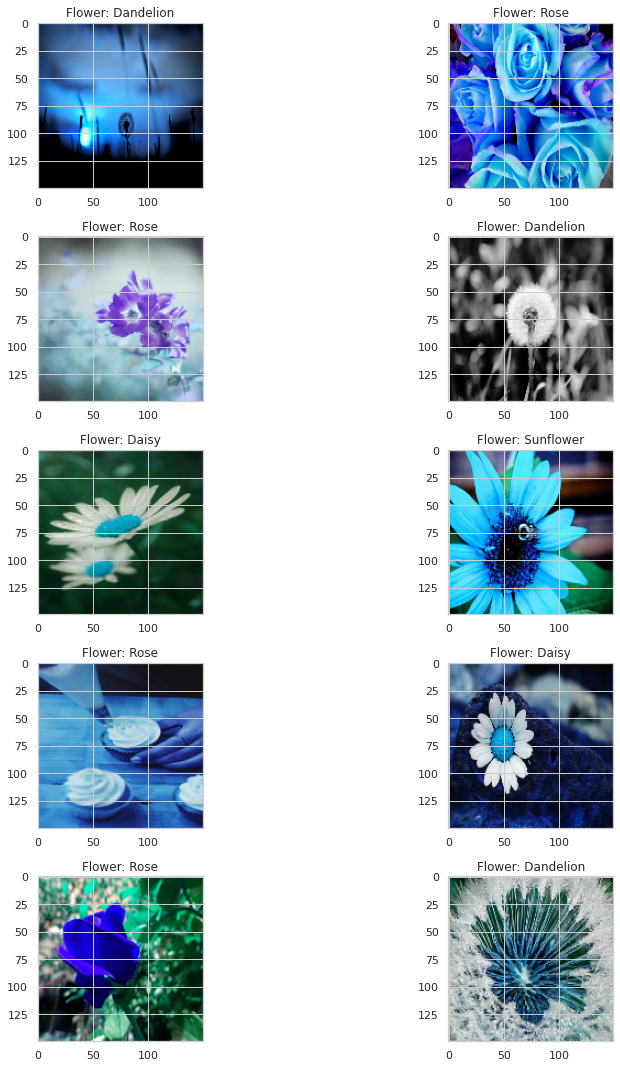

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

### 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [ ]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

### 2.4 ) Splitting into Training and Validation Sets

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### 2.5 ) Setting the Random Seeds

In [ ]:
np.random.seed(42)
rn.seed(42)
tf.compat.v1.set_random_seed(42)

## **3 ) Modelling**

### 3.1 ) Building the ConvNet Model

In [ ]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

### 3.2 ) Using a LR Annealer

In [ ]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### 3.3 ) Data Augmentation to prevent Overfitting

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### 3.4 ) Compiling the Keras Model & Summary

In [ ]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

### 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
25/25 [==============================] - 166s 7s/step - loss: 1.4120 - accuracy: 0.3824 - val_loss: 1.1991 - val_accuracy: 0.4676
Epoch 2/50
25/25 [==============================] - 167s 7s/step - loss: 1.1659 - accuracy: 0.5214 - val_loss: 1.0481 - val_accuracy: 0.5852
Epoch 3/50
25/25 [==============================] - 160s 6s/step - loss: 1.0923 - accuracy: 0.5629 - val_loss: 1.0943 - val_accuracy: 0.5528
Epoch 4/50
25/25 [==============================] - 161s 6s/step - loss: 1.0119 - accuracy: 0.5947 - val_loss: 0.9225 - val_accuracy: 0.6296
Epoch 5/50
25/25 [==============================] - 161s 6s/step - loss: 0.9175 - accuracy: 0.6398 - val_loss: 1.0006 - val_accuracy: 0.6009
Epoch 6/50
25/25 [==============================] - 161s 7s/step - loss: 0.9057 - accuracy: 0.6430 - val_loss: 0.8453 - val_accuracy: 0.6704
Epoch 7/50
25/25 [==============================] - 158s 6s/step - loss: 0.8512 - accuracy: 0.6652 - val_loss: 0.8412 - val_accuracy: 0.6667
Epoch 8/50
25

## **4 ) Evaluating the Model Performance**

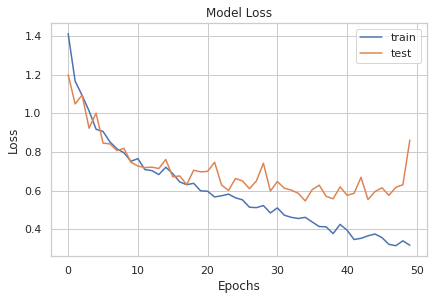

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

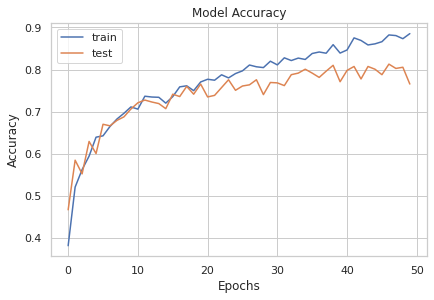

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## **5 ) Visualizing Predictons on the Validation Set**

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES

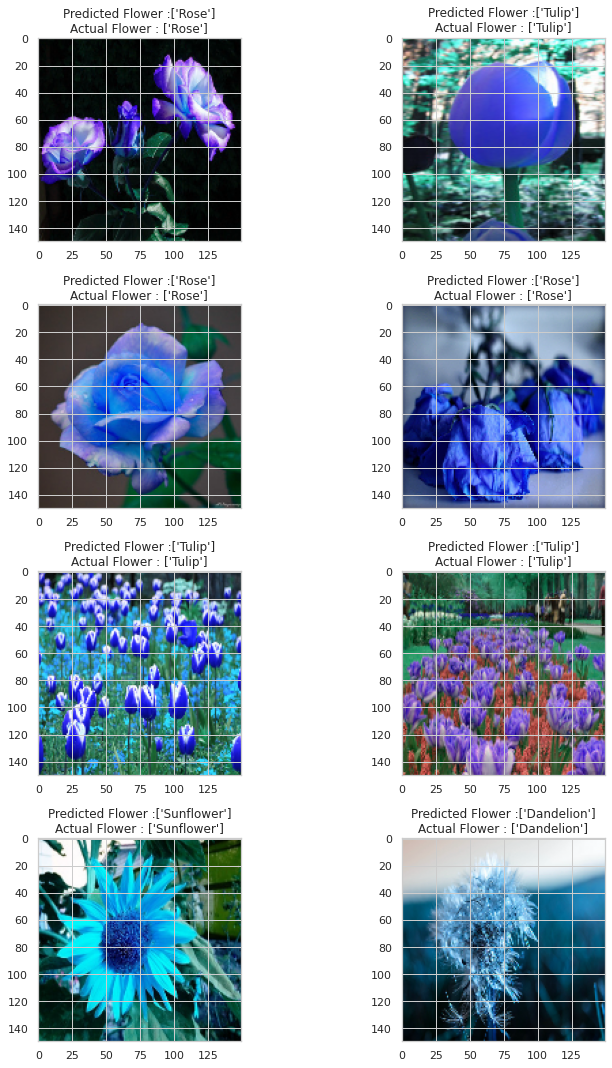

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1

MISCLASSIFIED IMAGES OF FLOWERS

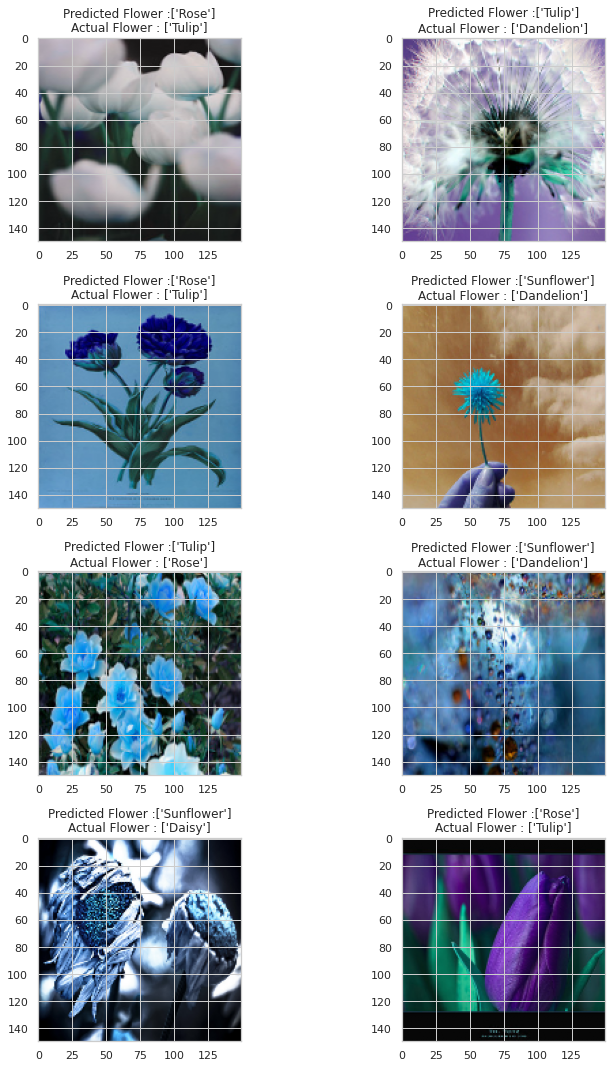

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1

# **05. 개/고양이 분류**
- 데이터셋을 배치 단위의 여러 부분으로 나누고 반복 객체(iterator)를 통해 각 배치를 한 개씩 모델에 입력하여 훈련
- ImageDataGenerator 함수 지원 

## **5-1. 분석 준비**

### 5-1-1. 데이터셋 다운로드
- https://www.kaggle.com/datasets/tongpython/cat-and-dog 
- zip 파일명을 cat-and-dog.zip 으로 변경
- 구글 드라이브에 'dataset' 으로 새 폴더 만들고 이 폴더에 zip 파일 업로드

### 5-1-2. 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

### 5-1-3. 구글 드라이브 마운트

In [2]:
# 구글 드라이브 폴더 마운트 (코랩을 사용하는 경우)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 5-1-4. 압축 파일 해제

In [3]:
# 압축 파일의 위치 (구글 드라이브 - 내 드라이브 위치)
drive_path = "/content/drive/MyDrive/" 
source_filename = drive_path + "dataset/cat-and-dog.zip"   

# 저장할 경로 
extract_folder = "dataset/"   # 코랩 환경에 임시 저장 

# 압축 해제 
import shutil
shutil.unpack_archive(source_filename, extract_folder) 

In [4]:
# 훈련 셋, 검증 셋 저장위치 지정
train_dir = extract_folder + "archive/training_set/training_set"
valid_dir = extract_folder + "archive/test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/archive/training_set/training_set
dataset/archive/test_set/test_set


## **5-2. 모델 학습**

### 5-2-1. ImageDataGenerator
- ImageDataGenerator 클래스 함수를 실행하고 rescale 옵션을 지정해 이미지 각 픽셀의 값을 0~1 범위로 정규화

In [5]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

### 5-2-2. flow_from_directory 함수
- ImageDataGenerator 객체에 flow_from_directory 함수를 적용하면, 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋을 처리
- batch_size=32 -> 배치를 구성하는 이미지 개수
- target_size=(224, 224) -> 저장될 이미지의 (세로,가로) 픽셀 사이즈
- classes=['cats','dogs'] -> 클래스 레이블(실제 이미지가 들어있는 하위 폴더 이름)
- class_mode = 'binary' -> 이진 분류 문제
- 훈련 셋, 검증 셋 모두 동일한 방식으로 제너레이터 객체 생성

In [6]:
# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen = image_gen.flow_from_directory(train_dir, 
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,                                          
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


- 1개의 배치를 선택해 배치 안에 들어 있는 32개의 이미지를 정답 클래스 레이블과 함께 출력

In [7]:
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


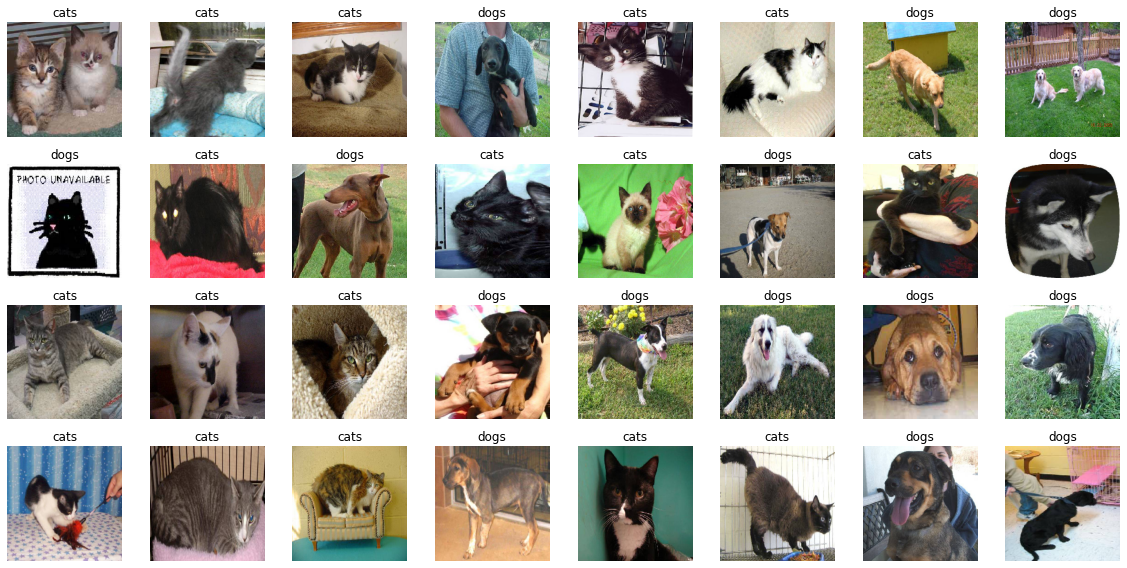

In [8]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis("off")

plt.tight_layout()
plt.show()

### 5-2-3. 모델 훈련
- 이진 분류 모델 정의
- '배치 정규화-합성곱-풀링'으로 구성된 단위블럭을 3개 반복하여 이미지로부터 다양한 피처를 추출하고, 최종 분류기로는 Dense 레이어 사용
- 최종 출력 레이어는 노드 1개를 갖고 활성화 함수로는 'sigmoid' 적용

In [9]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

model = build_model()

- 훈련 셋에 대한 정확도는 89%, 검증 셋에 대한 정확도는 76% 수준으로 과대적합 발생

In [10]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 42s 155ms/step - loss: 2.3762 - accuracy: 0.5743 - val_loss: 0.6618 - val_accuracy: 0.6303
Epoch 2/20
251/251 [==============================] - 40s 160ms/step - loss: 0.6394 - accuracy: 0.6274 - val_loss: 0.6435 - val_accuracy: 0.6337
Epoch 3/20
251/251 [==============================] - 39s 153ms/step - loss: 0.6072 - accuracy: 0.6537 - val_loss: 0.5836 - val_accuracy: 0.7029
Epoch 4/20
251/251 [==============================] - 39s 155ms/step - loss: 0.5840 - accuracy: 0.6798 - val_loss: 0.5545 - val_accuracy: 0.7093
Epoch 5/20
251/251 [==============================] - 38s 152ms/step - loss: 0.5643 - accuracy: 0.6874 - val_loss: 0.5610 - val_accuracy: 0.6940
Epoch 6/20
251/251 [==============================] - 38s 150ms/step - loss: 0.5443 - accuracy: 0.6996 - val_loss: 0.5341 - val_accuracy: 0.7257
Epoch 7/20
251/251 [==============================] - 40s 159ms/step - loss: 0.5167 - accuracy: 0.7284 - val_loss: 0.5229 - val_accuracy: 0.7

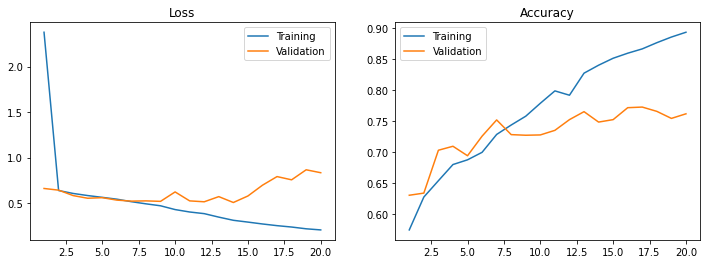

In [11]:
# 손실함수, 정확도 그래프 그리기 
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 20)

### 5-2-4. 데이터 증강

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255., 
                                   horizontal_flip=True,
                                   rotation_range=35,                                
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen_aug = image_gen_aug.flow_from_directory(train_dir, 
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,  
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Epoch 1/40
251/251 [==============================] - 122s 483ms/step - loss: 7.1604 - accuracy: 0.5467 - val_loss: 0.6631 - val_accuracy: 0.6253
Epoch 2/40
251/251 [==============================] - 121s 482ms/step - loss: 0.6294 - accuracy: 0.6413 - val_loss: 0.6335 - val_accuracy: 0.6792
Epoch 3/40
251/251 [==============================] - 121s 483ms/step - loss: 0.6135 - accuracy: 0.6586 - val_loss: 0.6064 - val_accuracy: 0.6599
Epoch 4/40
251/251 [==============================] - 121s 482ms/step - loss: 0.6060 - accuracy: 0.6558 - val_loss: 0.5441 - val_accuracy: 0.7266
Epoch 5/40
251/251 [==============================] - 121s 483ms/step - loss: 0.5933 - accuracy: 0.6678 - val_loss: 0.5804 - val_accuracy: 0.6950
Epoch 6/40
251/251 [==============================] - 121s 482ms/step - loss: 0.5876 - accuracy: 0.6787 - val_loss: 0.5673 - val_accuracy: 0.7064
Epoch 7/40
251/251 [====================

- 손실함수와 모델의 정확도 그래프를 보면, 과대적합 or 과소적합이 거의 발생하지 않고 학습이 잘 진행되는 것이 확인됨

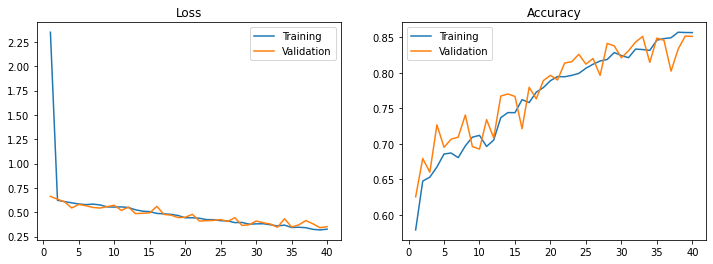

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(history_aug, 40)